<a href="https://colab.research.google.com/github/AKASH4671/Stock-Return-Forecasting-Using-LSTM-and-Machine-Learning/blob/main/02_Modeling_RF_and_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Install / import libraries**

Dropped 1 rows with NaN values.
▸ Random Forest
   MAE :  0.031645
   RMSE:  0.001914
   R²  : -0.0201

▸ XGBoost
   MAE :  0.032916
   RMSE:  0.002080
   R²  : -0.1084



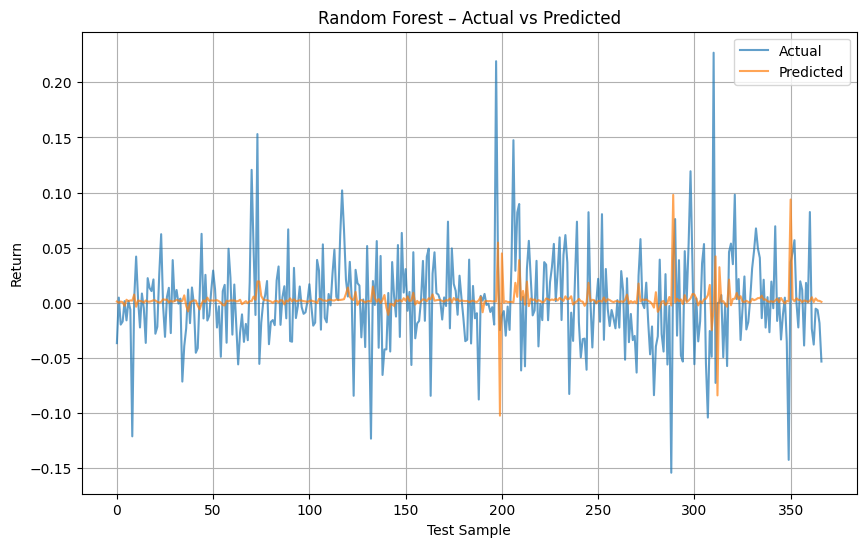

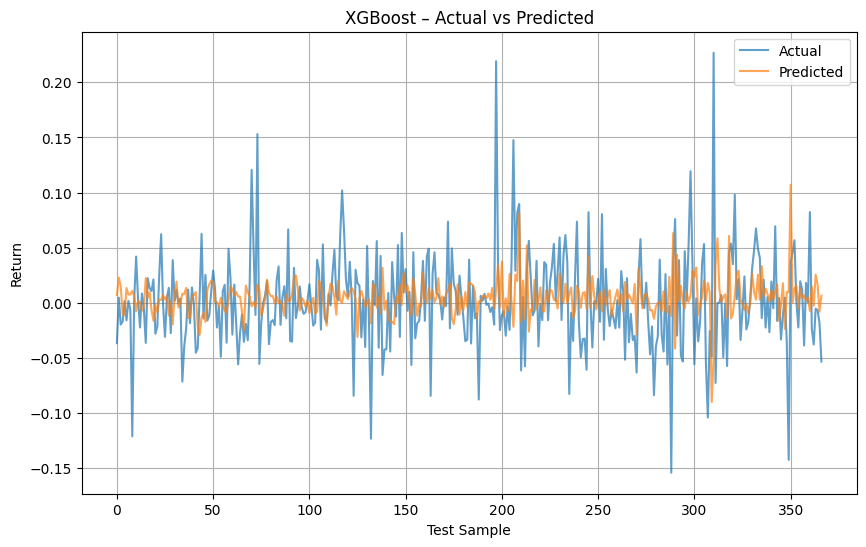

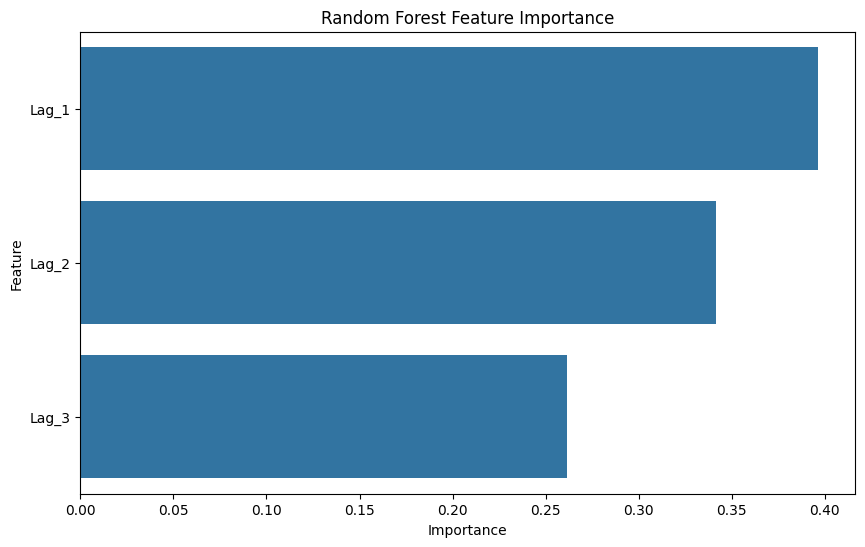

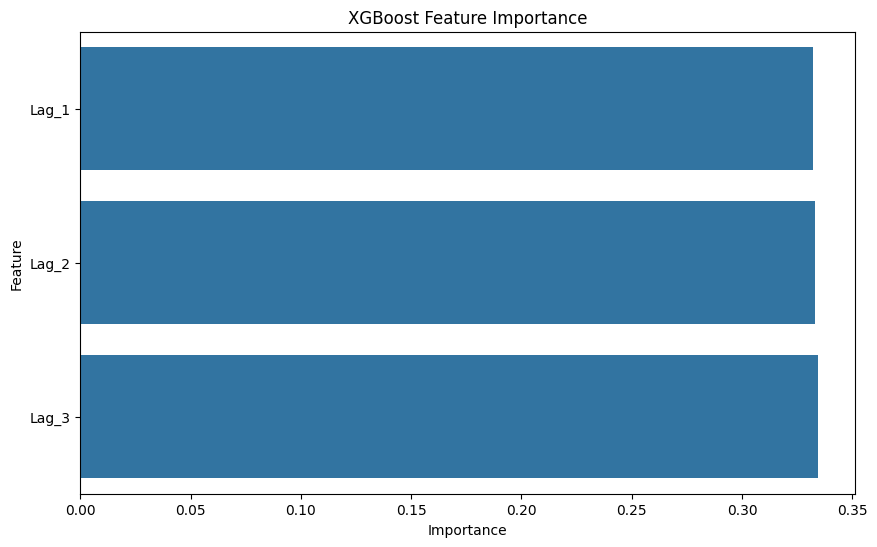


Models & predictions saved to: /content/drive/MyDrive/Colab Notebooks/Finance Projects/stock-price-prediction-ml/data


In [ ]:
!pip install xgboost --quiet

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
import joblib                    # for model persistence
import matplotlib.pyplot as plt
import seaborn as sns

# For consistent visuals
plt.rcParams["figure.figsize"] = (10, 6)

**Load pre‑processed data**

In [ ]:
# Path on Google Drive
csv_path = '/content/drive/MyDrive/Colab Notebooks/Finance Projects/Stock-Return-Forecasting-Using-LSTM-and-Machine-Learning/data/tsla_preprocessed.csv'
df = pd.read_csv(csv_path)

# Drop rows with any NaN values before splitting
initial_rows = len(df)
df.dropna(inplace=True)
rows_dropped = initial_rows - len(df)
print(f"Dropped {rows_dropped} rows with NaN values.")


features = ['Lag_1', 'Lag_2', 'Lag_3']
target   = 'Return'

X = df[features].values
y = df[target].values

**Train‑test split & scaling**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

**Random Forest Regressor**

In [ ]:
rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=6,
        random_state=42,
        n_jobs=-1)

rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)

**XGBoost Regressor**

In [ ]:
xgb = XGBRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='reg:squarederror',
        n_jobs=-1)

xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)

**Evaluation helper**

In [ ]:
def evaluate(y_true, y_pred, model_name):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) # Removed squared=False
    r2   = r2_score(y_true, y_pred)
    print(f'▸ {model_name}')
    print(f'   MAE : {mae: .6f}')
    print(f'   RMSE: {rmse: .6f}')
    print(f'   R²  : {r2: .4f}\n')
    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

results = []
results.append(evaluate(y_test, rf_pred,  'Random Forest'))
results.append(evaluate(y_test, xgb_pred, 'XGBoost'))


**Plot Actual vs Predicted**

In [ ]:
def plot_pred(y_true, y_pred, title):
    plt.figure()
    plt.plot(y_true, label='Actual', alpha=0.7)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.xlabel('Test Sample')
    plt.ylabel('Return')
    plt.grid(True)
    plt.show()

plot_pred(y_test, rf_pred,  'Random Forest – Actual vs Predicted')
plot_pred(y_test, xgb_pred, 'XGBoost – Actual vs Predicted')

**Feature Importance (both models)**

In [ ]:
def plot_importance(importances, names, title):
    sns.barplot(x=importances, y=names, orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

rf_imp  = rf.feature_importances_
xgb_imp = xgb.feature_importances_ # Corrected to use feature_importances_

plot_importance(rf_imp,  features, 'Random Forest Feature Importance')
plot_importance(xgb_imp, features, 'XGBoost Feature Importance')


**Save models & predictions to Google Drive**

In [ ]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/Finance Projects/Stock-Return-Forecasting-Using-LSTM-and-Machine-Learning/data/'

joblib.dump(rf,  save_dir + 'rf_model.pkl')
joblib.dump(xgb, save_dir + 'xgb_model.pkl')
joblib.dump(scaler, save_dir + 'scaler.pkl')

pred_df = pd.DataFrame({
    'Actual': y_test,
    'RF_Pred': rf_pred,
    'XGB_Pred': xgb_pred
})
pred_df.to_csv(save_dir + 'test_predictions.csv', index=False)

print(f'\nModels & predictions saved to: {save_dir}')